In [1]:
from surprise import BaselineOnly
from surprise import NMF
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
import os
from surprise import accuracy
from surprise.model_selection import KFold
# from surprise import SVD
from scipy import sparse
import matplotlib.pyplot as plt
import sklearn

In [2]:
import numpy as np
import pandas as pd
import datetime
import random
from time import time
import math
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from multiprocessing import Pool
import timeit

my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

In [3]:
class RatingDataset:
    import numpy as np
    from scipy import sparse
    
    def __init__(self):
        self.rating_mat = None
        self.time_mat = None
        self._data_file_path = ''
        
        # list of raw user_IDs (dataset IDs)
        self.items = []
        self.users = []
        self.item_n = 0
        self.user_n = 0
        
        # maps raw user_id to user_iid(or innder id)
        self.user_to_iid = {}
        # maps user inner id to dataset raw ID
        self.user_to_ID = {}
        # maps raw item_id (dataset) to item_iid(or inner id)
        self.item_to_iid = {}
        # maps item inner id to dataset raw ID
        self.item_to_ID = {}
        
        # list of triples of (item, rating, timestamp) for each user_iid. 
        # TODO: In case there were no Timestamp in the data, pairs of (item, rating) will be kept
        self.user_ratings = []
        # list of pair of (user, rating) for each item_iid
        self.item_ratings = []
        
        
    def __get_line_format_indices(self, line_format):
        # specifying the order of 'user, item, rating, timestamp' in each line 
        lf_sp = line_format.split(' ')
        if len(lf_sp) != 3:
            raise Exception('''Bad line format!
            line_format should be space-separated and it should always specified by 
            "user item rating" with any order!''')
        user_idx = -1
        item_idx = -1
        rating_idx = -1
        timestamp_idx = -1
        for c in range(len(lf_sp)):
            if lf_sp[c] == 'user':
                user_idx = c
            elif lf_sp[c] == 'item':
                item_idx = c
            elif lf_sp[c] == 'rating':
                rating_idx = c
#             elif lf_sp[c] == 'timestamp':
#                 timestamp_idx = c
            else:
                raise Exception('line_format must be exactly dictated by one of: (user/item/rating) separated by sep!')
        
        return user_idx, item_idx, rating_idx
    
    
    '''
        Read the rating data from file and parse it and then make the dataset.
    '''
    def read_from_file(self, data_fn, skip_lines=0, sep=',', line_format='user item rating timestamp'):
        
        user_fmt_idx, item_fmt_idx, rating_fmt_idx = self.__get_line_format_indices(line_format)
        
        file = open(data_fn, 'r')
        
        # skip lines that are specified from input
        for _ in range(skip_lines):
            file.readline()
            
        # users list as in input file
        users_lin = []
        items_lin = []
        ratings_lin = []
#         timestamps_lin = []
        for l in file:
            lsp = l.split(sep)
            user_id = lsp[user_fmt_idx]
            item_id = lsp[item_fmt_idx]
            rating = float(lsp[rating_fmt_idx])
#             timestamp = int(lsp[timestamp_fmt_idx].strip('\n'))
            
            users_lin.append(user_id)
            items_lin.append(item_id)
            ratings_lin.append(rating)
#             timestamps_lin.append(timestamp)
            
        self.users = list(set(users_lin))
        self.items = list(set(items_lin))
        
        self.user_n = len(self.users)
        self.item_n = len(self.items)
        
        # set the mappings
        for idx in range(self.user_n): 
            self.user_to_iid[self.users[idx]] = idx
        for idx in range(self.user_n):
            self.user_to_ID[idx] = self.users[idx] 
        for idx in range(self.item_n):
            self.item_to_iid[self.items[idx]] = idx 
        for idx in range(self.item_n):
            self.item_to_ID[idx] = self.items[idx] 
        
        # init rating matrix
        self.rating_mat = sparse.lil_matrix((self.user_n, self.item_n))
#         self.time_mat = sparse.lil_matrix((self.user_n, self.item_n))
        for idx in range(len(users_lin)):
            user_iid = self.user_to_iid[users_lin[idx]]
            item_iid = self.item_to_iid[items_lin[idx]]
            rating = ratings_lin[idx]
            self.rating_mat[user_iid, item_iid] = rating
#             self.time_mat[user_iid, item_iid] = timestamps_lin[idx]
            
            
    def list_users_ratings(self, rating_matrix):
        # finding the user and item ratings
        user_ratings = []
        for user_iid in range(self.user_n):
            # append a list for this user
            user_ratings.append([])
            user_nonze = np.nonzero(rating_matrix[user_iid])
            for item_iid in user_nonze[1]:
                # add items and its rating into the last user added to the list
                user_ratings[-1].append((item_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return user_ratings
    
            
    def list_items_ratings(self, rating_matrix):
        item_ratings = []
        for item_iid in range(self.item_n):
            # append a list for this item
            item_ratings.append([])
            item_nonze = np.nonzero(rating_matrix.T[item_iid])
            for user_iid in item_nonze[1]:
                # add users and its rating into the last item added to the list
                item_ratings[-1].append((user_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return item_ratings
        
            
    def train_test_split(self, test_percent=0.2, least_userlen_test=10):
        if test_percent > 1:
            raise Exception('test_percent should be between 0 and 1.')
            
        user_ratings = self.list_users_ratings(self.rating_mat)
        
        mat = sparse.lil_matrix((self.user_n, self.item_n))
        user_tests = {}
        n_users_in_test = 0
        n_ratings_in_test = 0
        n_ratings_in_train = 0
        
        for user_iid in range(self.user_n):
            len_u = len(user_ratings[user_iid])
            if len_u >= least_userlen_test:
                n_users_in_test += 1
                test_len = int(len_u * test_percent)
                test_set_u = list(range(len_u))
#                 print(test_len, len_u)
                random.shuffle(test_set_u)
                
                train_set_u = test_set_u[test_len:][:]
                test_set_u = test_set_u[:test_len][:]
                
#                 print(len(train_set_u))
                
                for ir_idx in train_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
                
                user_tests[user_iid] = []
                for ir_idx in test_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    user_tests[user_iid].append(ir)
                    n_ratings_in_test += 1
                    
            else: # if no test set should be seprated from ratings of this user
                for ir in user_ratings[user_iid]:
                    # ir = the pair of (item, rating)
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
    
        print('Number of users with some items in testset: %d' % n_users_in_test)
        print('Number of ratings in trainset: %d \t Number of ratings in testset: %d' % (n_ratings_in_train, n_ratings_in_test))
        return mat, user_tests

In [4]:
dataset = RatingDataset()
data_fn = 'data/Kiva/rating_5000_cls_hc_10core_iterative.csv'
dataset.read_from_file(data_fn, line_format='user item rating', sep='\t')

In [5]:
print(dataset.user_n)
print(dataset.item_n)

4005
2673


In [6]:
train_mat, user_tests = dataset.train_test_split(test_percent=0.2, least_userlen_test=10)

Number of users with some items in testset: 4005
Number of ratings in trainset: 89678 	 Number of ratings in testset: 20693


In [7]:
user_ratings = dataset.list_users_ratings(dataset.rating_mat)

In [8]:
dataset.rating_mat.shape

(4005, 2673)

### saving training and test sets

In [9]:
# test set
u_t_list = []

for uid in user_tests.keys():
    base_rec = pd.DataFrame(user_tests[uid])
    base_rec[2] = uid
    u_t_list.append(base_rec[[2,0,1]])

u_t_df = pd.concat(u_t_list, ignore_index=True)
u_t_df.columns=['userid', 'itemid', 'rating']
u_t_df.to_csv('./UMAP2020_CameraReady/test_recs_kiva.csv', index=False, header=None)

In [10]:
np.save('./UMAP2020_CameraReady/trainmatrix_kiva.npy', train_mat.toarray())

# Evaluation
mat: Training data sparse matrix

user_tests: A dictionary for each user(key) stores the set of items that is positively rated(>= 4stars) by this user.

In [11]:
import math
# ground_truth: list of items ordered by time
def nDCG_Time(ground_truth, _recList):
    rec_num = len(_recList) #topK
    # ground_truth is already sorted by time
    idealOrder = ground_truth
    idealDCG = 0.0
    for j in range(min(rec_num, len(idealOrder))):
        idealDCG += ((math.pow(2.0, len(idealOrder) - j) - 1) / math.log(2.0 + j))

    recDCG = 0.0
    for j in range(rec_num):
        item = _recList[j]
        if item in ground_truth:
            rank = len(ground_truth) - ground_truth.index(item) # why ground truth?
            recDCG += ((math.pow(2.0, rank) - 1) / math.log(1.0 + j + 1))

    return (recDCG / idealDCG)


def Recall(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_test_set))


def Precision(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_recList))


In [12]:
# Intra List Distance
def ILD(_recList):
    
    
    # convert inner ids to imdbids
    _recList_if_ids = [InnerID_to_iiMatrixID[Inner_ID] for Inner_ID in _recList]
    _recList_if_ids = list(map(int, _recList))

    totalDisSimilarityPerUser = 0
    topK =  len(_recList)
    
    
            
    totalDisSimilarityPerUser = 0
    topK =  len(_recList)
    
    for item_i in _recList_if_ids:
        for item_j in _recList_if_ids:
             if (item_i != item_j):
                # this vector (i) and that vector (j)
                totalDisSimilarityPerUser += (1.0 - itemItemSimilarityByFeature[item_i, item_j])
    
#     c = []
#     for item_i in _recList_if_ids:
#         if (item_i >= itemItemSimilarityByFeature.shape[0]) or (item_i >= itemItemSimilarityByFeature.shape[1]):
#             c.append(item_i) 
#             continue
            
#         for item_j in _recList_if_ids:
#             if (item_j >= itemItemSimilarityByFeature.shape[0]) or (item_i >= itemItemSimilarityByFeature.shape[1]):
#                 c.append(item_j) 
#                 continue
#             if (item_i != item_j):
#                 # this vector (i) and that vector (j)
#                 totalDisSimilarityPerUser += (1.0 - itemItemSimilarityByFeature[item_i, item_j])
#     print("# of rec ids not in item_feature_df",len(set(c)))
    
    diversityPerUser = (totalDisSimilarityPerUser * 2.0) / (topK * (topK - 1.0))
    return (diversityPerUser)


def ENTROPY_(_recList):
    
    # given a user id, it calcualtes the entropy for the recommendation list of a user
    _recList_ids = list(map(int, _recList))
    feature_count_vector = item_features_df[item_features_df.index.isin(_recList_ids)].sum(axis=0)
    
    # turn it back to a list of labels so we can pass it to entropy_()
    # _recList_item_features = [i for i in feature_count_vector[feature_count_vector != 0].index for j in range(feature_count_vector[i])]
    _recList_item_features = [i for i in feature_count_vector[feature_count_vector != 0].index]

    # send the labels to the entropy_() to calculate the netropy over all the labels combined.
    return entropy_(_recList_item_features)

    
def entropy_(labels, base=None):
    from math import log, e
    """ Computes entropy of label distribution. """

    n_labels = len(labels)
    if n_labels <= 1:
        return 0

    value, counts = np.unique(labels, return_counts=True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0
    
    ent = 0.

    # Compute entropy
    base = e if base is None else base
    for i in probs:
        ent -= i * log(i, base)

    return ent

In [13]:
def KullbackLeiblerDivergence(interactDist, recommendedDist):
    import numpy as np
    alpha = 0.01 # not really a tuning parameter, it's there to make the computation more numerically stable.
    klDive = 0.0
    for i in range(len(interactDist)):
        # By convention, 0 * ln(0/a) = 0, so we can ignore keys in q that aren't in p
        if interactDist[i] == 0.0:
            continue
        # if q = recommendationDist and p = interactedDist, q-hat is the adjusted q.
        # given that KL divergence diverges if recommendationDist or q is zero, we instead use q-hat = (1-alpha).q + alpha . p
        recommendedDist[i] = (1 - alpha) * recommendedDist[i] + alpha * interactDist[i]
        klDive += interactDist[i] * np.log2(interactDist[i] / recommendedDist[i])

    return klDive

def ComputeGenreDistribution(itemList, item_features_df):
    return item_features_df[item_features_df.index.isin(itemList)].sum(axis=0) / len(itemList)


# it's calculated for each user
def Calibration(groundTruth, _recList):
    
    recommendedDist = ComputeGenreDistribution(_recList, item_features_df)
    interactDist = ComputeGenreDistribution(groundTruth, item_features_df)
    
    klDive = KullbackLeiblerDivergence(interactDist, recommendedDist)
    return klDive

In [14]:
# def isProtected(itemId):
#     if item_features_df.loc[item_features_df.index == itemId,
#                            [ 'Horror', 'History','Music', '']].sum(axis=1).values[0] > 0:
#         return True
#     return False

### reading item-feature matrix

In [15]:
item_features_df = pd.read_csv('./data/Kiva/loan_feature_matrix_hc_10core.csv', dtype=int)
item_features_df.set_index('pseudoitemid', inplace=True)
print(item_features_df.shape)
item_features_df.head()

(2673, 231)


,ACTIVITY_Agriculture,ACTIVITY_Air Conditioning,ACTIVITY_Animal Sales,ACTIVITY_Aquaculture,ACTIVITY_Arts,ACTIVITY_Auto Repair,ACTIVITY_Bakery,ACTIVITY_Barber Shop,ACTIVITY_Beauty Salon,ACTIVITY_Beekeeping,...,loan_buck_4,loan_buck_5,loan_buck_6,loan_buck_7,loan_buck_8,loan_buck_9,pfr_buck_0,pfr_buck_1,pfr_buck_2,pfr_buck_3
pseudoitemid,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


# Adding the INNER item IDs to the item_feature dataframe

In [16]:
e = 0
inner_ids = []
for idx, row in item_features_df.iterrows():
    try:
        inner_ids.append(dataset.item_to_iid[str(int(idx))])
    except KeyError:
        e += 1
print(e)
item_features_df.head()

0


,ACTIVITY_Agriculture,ACTIVITY_Air Conditioning,ACTIVITY_Animal Sales,ACTIVITY_Aquaculture,ACTIVITY_Arts,ACTIVITY_Auto Repair,ACTIVITY_Bakery,ACTIVITY_Barber Shop,ACTIVITY_Beauty Salon,ACTIVITY_Beekeeping,...,loan_buck_4,loan_buck_5,loan_buck_6,loan_buck_7,loan_buck_8,loan_buck_9,pfr_buck_0,pfr_buck_1,pfr_buck_2,pfr_buck_3
pseudoitemid,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [17]:
item_features_df['innerID'] = inner_ids
item_features_df.set_index('innerID', inplace=True)
item_features_df.head()

,ACTIVITY_Agriculture,ACTIVITY_Air Conditioning,ACTIVITY_Animal Sales,ACTIVITY_Aquaculture,ACTIVITY_Arts,ACTIVITY_Auto Repair,ACTIVITY_Bakery,ACTIVITY_Barber Shop,ACTIVITY_Beauty Salon,ACTIVITY_Beekeeping,...,loan_buck_4,loan_buck_5,loan_buck_6,loan_buck_7,loan_buck_8,loan_buck_9,pfr_buck_0,pfr_buck_1,pfr_buck_2,pfr_buck_3
innerID,,,,,,,,,,,,,,,,,,,,,
2655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1499,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2201,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
546,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [18]:
item_features_df.to_csv('./UMAP2020_CameraReady/loan_feature_matrix_hc_10core_innerID_Kiva.csv')

In [19]:
item_features_df.shape

(2673, 231)

In [20]:
cols = list(item_features_df.columns)
# ACTIVITY_, COUNTRY_, GENDER_, loan_buck_, pfr_buck_ in their name

### item-item similarity based on features

In [21]:
# Turning inner_ID to innerid for this item item similarity matrix
InnerID_to_iiMatrixID = {}
iiMatrixID_to_InnerID = {}

for i in range(item_features_df.shape[0]):
    iiMatrixID_to_InnerID[i] = item_features_df.index[i]
    InnerID_to_iiMatrixID[item_features_df.index[i]] = i

# print(InnerID_to_iiMatrixID[1606])

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
itemItemSimilarityByFeature = cosine_similarity(item_features_df.values)
print (itemItemSimilarityByFeature.shape)

(2673, 2673)


In [23]:
def recNMF_2(user_iid, _est, mat, topk):
    
    rated_before = np.nonzero(mat[user_iid, :])[1]
    estimations = _est[user_iid]
    estimations[rated_before] = 0 
    # you don't want to recommend the items to the user that have rated before!
    
    top_items = np.argsort(-estimations)[:topk]
    top_ratings = -np.sort(-estimations)[:topk]
    
    return (user_iid, top_items, top_ratings)

# RECSYS - Base recommender algorithm

In [24]:
start = timeit.default_timer()
from sklearn.decomposition import NMF
feature_n = 40

mf = NMF(n_components=feature_n, init='random', random_state=2, tol=0.01,
         solver='cd', max_iter=1000, alpha=1, beta_loss='frobenius',
         l1_ratio=0)


user_f = mf.fit_transform(train_mat)
H = mf.components_
item_f = mf.components_.T

stop = timeit.default_timer()
print('Process Time: %.2f secs' % (stop - start))
start = timeit.default_timer()
est = np.dot(user_f, item_f.T)
res = []

# Choose it to be 200 instead of 10, and then the re-ranker will choose the final top 10
for u in range(dataset.user_n):
    res.append(recNMF_2(u, est, train_mat, 200))

# Saving the base recommendations into a file.
u_rec_list = []
for i in range(len(res)):
    base_rec = pd.DataFrame(res[i][1:]).T
    base_rec[2] = res[i][0]
    u_rec_list.append(base_rec[[2,0,1]])

u_rec_df = pd.concat(u_rec_list, ignore_index=True)
u_rec_df.columns = ['userid', 'itemid', 'rating']
print('\n', u_rec_df.head())
u_rec_df.to_csv('./UMAP2020_CameraReady/nmf_base_rec_Kiva.csv', index=False, header=None)

Process Time: 0.41 secs

    userid  itemid    rating
0       0  1747.0  0.606330
1       0   421.0  0.477415
2       0  1136.0  0.368145
3       0  2530.0  0.338891
4       0  1693.0  0.300224


## Evaluation

In [25]:
def evaluation(groundTruth, recs):
    import timeit
    start = timeit.default_timer()

    p = []
    r = []
    n = []
    ild = []
    ent = []
    calib = []


    for u in np.unique(groundTruth['userid'].tolist()):
        if len(groundTruth[groundTruth['userid'] == u]) > 0:

    #         test_items = [t[0] for t in user_tests[u] if t[1] >= 4]
            test_items = list(map(int,groundTruth.loc[groundTruth['userid'] == u,'itemid'].tolist()))

            if len(test_items) > 0:
                # top items
                top_items = list(map(int,recs.loc[recs['userid'] == u, 'itemid'].tolist()))[:10]

                recall = Recall(test_items, top_items)
                precision = Precision(test_items, top_items)
                ndcg = nDCG_Time(test_items, top_items)

                # only top_items or recommendation list is needed for diversity
                diversity_ild = ILD(top_items)
                diversity_entropy = ENTROPY_(top_items)

                calibration_s = Calibration(test_items, top_items)


                r.append(recall)
                p.append(precision)
                n.append(ndcg)
                ild.append(diversity_ild)
                ent.append(diversity_entropy)
                calib.append(calibration_s)


    stop = timeit.default_timer()
    print('Process Time: %.2f secs' % (stop - start))
    
    print (" avg-precision %.3f\n avg-recall %.3f\n avg-nDCG %.3f\n avg-ILD %.3f\n avg-ENTROPY %.3f\n" %
       (np.average(p),np.average(r),np.average(n),np.average(ild),np.average(ent)))

#     print (" avg-precision %.3f\n avg-recall %.3f\n avg-nDCG %.3f" % (np.average(p),np.average(r),np.average(n)))


In [26]:
# 40 factors
evaluation(u_t_df, u_rec_df)

Process Time: 30.74 secs
 avg-precision 0.061
 avg-recall 0.121
 avg-nDCG 0.076
 avg-ILD 1.614
 avg-ENTROPY 3.004



Process Time: 33.88 secs
 avg-precision 0.063
 avg-recall 0.127
 avg-nDCG 0.083
 avg-ILD 1.602
 avg-ENTROPY 2.989

In [27]:
# rec list has inner ids?
# groundtruth has inner ids or outer ids?
# YES!

# RECSYS + MMR RE-RANKER
## lambda * recommendation score - (1 - lambda) * cosine similarity

In [28]:
import numpy as np
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler

In [29]:
import warnings
warnings.filterwarnings("error")

def mmr(u, items, lam, top_k, w=None):
    
    scaler = MinMaxScaler()
    scaled_ratings = scaler.fit_transform(res[u][2].reshape(-1,1))[:,0]
    
    c = 0
    s = []
    for k in range(top_k): # top_k means choose top k items for the final re-ranking.
        all_sc = []
        for i in res[u][1]: #[100, 101, 102]
            p2 = 0
            for j in s:
                try:
                    p = (1 - distance.cosine(item_features_df.loc[str(item_iid_to_imdb(i))].values,
                                             item_features_df.loc[str(item_iid_to_imdb(j))].values,
                                             w)) # weight
                    p2 += p
                except KeyError as e:
                    pass
                
                except RuntimeWarning:
                    print (p)

            r = scaled_ratings[res[u][1].tolist().index(i)]  
            # get the index of an itemid and get the rating related to it
            sc = lam * r - (1-lam) * p2
            # find the index of a user id and then go to that index to retrieve the score
            all_sc.append(sc) # 0.1 0.5 0.2
            
        sc_asorted = np.argsort(all_sc)[::-1] #[1, 2, 0]
        sc_idx = 0
        top_item = res[u][1][sc_asorted[0]]
        
        # if top item already exists in the list, pick the second best item or the third best item
        while top_item in s:
            top_item = res[u][1][sc_asorted[sc_idx]]
            sc_idx += 1
        s.append(top_item)

        
    top_ratings = [res[u][2][list(res[u][1]).index(i)] for i in s]
    return (u, s, top_ratings)

In [30]:
import warnings
warnings.filterwarnings("error")

def mmr_opt(u, items, lam, top_k, w=None):
    
    new_rec_i = []
    new_rec_sc = []
    for i in range(len(res[u][1])):
        if res[u][1][i] in item_features_df.index:
            new_rec_i.append(res[u][1][i])
            new_rec_sc.append(res[u][2][i])
    new_rec_i = np.array(new_rec_i)
    new_rec_sc = np.array(new_rec_sc)

    scaler = MinMaxScaler()
    scaled_ratings = scaler.fit_transform(new_rec_sc.reshape(-1,1))[:,0]
    
    
    if w is not None:
        dists = sklearn.metrics.pairwise_distances(np.sqrt(w) * item_features_df.loc[new_rec_i], metric='cosine', n_jobs=1)
    else:
        dists = sklearn.metrics.pairwise_distances(item_features_df.loc[new_rec_i], metric='cosine', n_jobs=1)
        

    c = 0
    s = []
    for k in range(top_k): # top_k means choose top k items for the final re-ranking.
        all_sc = []
        for rec_idx in range(len(new_rec_i)):
            p2 = 0
            for j in s:
                try:
                    p = 1 - dists[rec_idx, new_rec_i.tolist().index(j)]
#                     print('%d   %.2f' % (new_rec_i[rec_idx], p))
                    p2 += p
                except KeyError as e:
                    pass

            r = scaled_ratings[rec_idx]
            # get the index of an itemid and get the rating related to it
            sc = lam * r - (1-lam) * p2
            # find the index of a user id and then go to that index to retrieve the score
            all_sc.append(sc) # 0.1 0.5 0.2
            
            
        sc_asorted = np.argsort(all_sc)[::-1] #[1, 2, 0]
        sc_idx = 0
        top_item = new_rec_i[sc_asorted[0]]
        
        # if top item already exists in the list, pick the second best item or the third best item
        while top_item in s:
            top_item = new_rec_i[sc_asorted[sc_idx]]
            sc_idx += 1
        s.append(top_item)

        
    top_ratings = [new_rec_sc[list(new_rec_i).index(i)] for i in s]
    
    return (u, s, top_ratings)

In [31]:
# testing

In [32]:
# mmr_opt(1, item_features_df, 0.5, 10, user_genre_matrix_df.loc[1])

In [33]:
#  mmr_opt(1, item_features_df, 0.5, 10)

### running mmr with different lambdas

In [34]:
def save_recommendations(recommendations, filename):
    u_rec_list = []
    for i in range(len(recommendations)):
        base_rec = pd.DataFrame(recommendations[i][1][1:]).T
        base_rec[2] = recommendations[i][1][0]
        u_rec_list.append(base_rec[[2,0,1]])

    u_rec_df = pd.concat(u_rec_list, ignore_index=True)
    u_rec_df.to_csv('./UMAP2020_CameraReady/kiva_results/' + filename, index=False, header=None)
    return

# 1. Content-based MMR

In [35]:
start = timeit.default_timer()
for lam in [0.2, 0.4, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.87, 0.9, 0.93, 0.95, 0.97, 0.99, 1.0]:
    
    print(lam)
    top_k = 10
    rr_recs = []
    
    def compute_mmr(u):
        return (u, mmr_opt(u, item_features_df, lam, top_k))

    pool = Pool(processes=10)
    rr_recs = pool.map(compute_mmr, list(range(dataset.user_n)))
    pool.close()
    pool.join()  
    
    save_recommendations(rr_recs, 'rec_MMR_lam%s.csv'%lam)

stop = timeit.default_timer()
print('Process Time: %.2f secs' % (stop - start))

0.2
0.4
0.6
0.65
0.7
0.75
0.8
0.85
0.87
0.9
0.93
0.95
0.97
0.99
1.0
Process Time: 1433.34 secs


## Calculating user tolerance weight as a dictionary e.g. {userid: {f1: entropy, f2: entropy, f3:entropy}}

In [36]:
userid_tolerance_dict = {} # key:userid, & value: a dictionary of genre : tolerance

# for k in ['ACTIVITY', 'COUNTRY', 'GENDER', 'LOAN_BUCKET', 'PFR_BUCKET']:
#     empty_dict[k] = 0.0
    
# ACTIVITY_, COUNTRY_, GENDER_, loan_buck_, pfr_buck_ in their name

for userid in range(dataset.user_n):
    
    # creating an empty dictionary
    empty_dict = {}
    for k in ['ACTIVITY', 'COUNTRY', 'GENDER', 'LOAN_BUCKET', 'PFR_BUCKET']:
        empty_dict[k] = []

    # inner ids
    items_rated_before = np.nonzero(train_mat[userid, :])[1]
    i_f = item_features_df[item_features_df.index.isin(items_rated_before)].sum()
    
    for i in range(i_f.index.shape[0]):
        
        if 'ACTIVITY' in i_f.index[i]:
            empty_dict['ACTIVITY'].extend([i_f.index[i]] * int(i_f[i]))
        elif 'COUNTRY' in i_f.index[i]:
            empty_dict['COUNTRY'].extend([i_f.index[i]] * int(i_f[i]))
        elif 'GENDER' in i_f.index[i]:
            empty_dict['GENDER'].extend([i_f.index[i]] * int(i_f[i]))
        elif 'loan_buck' in i_f.index[i]:
            empty_dict['LOAN_BUCKET'].extend([i_f.index[i]] * int(i_f[i]))
        elif 'pfr_buck' in i_f.index[i]:
            empty_dict['PFR_BUCKET'].extend([i_f.index[i]] * int(i_f[i]))
            
        else:
            print('no feature found')
            
    # calculate entropy for each user over all the features
    # this is problematic for users who have a short profile.
    tolerance_dict = {} # feature: entropy
    for k, v in empty_dict.items():
        tolerance_dict[k] = entropy_(v)

    # {userid: {feature: entropy}}
    userid_tolerance_dict[userid] = tolerance_dict

print(len(userid_tolerance_dict))

4005


In [37]:
userid_tolerance_dict[0]

{'ACTIVITY': 2.1972245773362196,
 'COUNTRY': 2.1972245773362196,
 'GENDER': 0.6869615765973234,
 'LOAN_BUCKET': 1.7351264569629223,
 'PFR_BUCKET': 1.2730283365896256}

In [38]:
# np.array(list(userid_tolerance_dict[0].values())).reshape(-1,1)

In [39]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

### Turning the userid_tolerance_dict into a matrix where each row is user id and columns are features and the values are entropies. Once we normalize the entropy based on users(rows) and once based on features(columns). We normalize the values so it is between 0 and 2.

In [40]:
# userid_tolerance_dict
from sklearn.feature_extraction import DictVectorizer

# Create DictVectorizer object
dictvectorizer = DictVectorizer(sparse=False)

# Convert dictionary into feature matrix
features = dictvectorizer.fit_transform(userid_tolerance_dict.values())

# get column names
print (dictvectorizer.get_feature_names(),'\n')
print (features[:5])

['ACTIVITY', 'COUNTRY', 'GENDER', 'LOAN_BUCKET', 'PFR_BUCKET'] 

[[2.19722458 2.19722458 0.68696158 1.73512646 1.27302834]
 [2.60238078 2.37411127 0.67652596 2.07448973 1.30106094]
 [2.21025358 1.23426787 0.67919327 1.5171064  1.30860539]
 [3.71000762 2.89875188 0.56233514 2.194738   1.37396869]
 [2.25385759 2.21025358 0.         2.02280853 1.35797785]]


# Transform the whole tolerance (feature) matrix between 0 and 1

In [41]:
# (X - MIN / MAX - MIN) * (NEW_MAX - NEW_MIN) + NEW_MIN
feature_max = np.max(features)
feature_min = np.min(features)
new_min = 0
new_max = 1

# print(feature_max, feature_min)
sc = (features - feature_min) / (feature_max - feature_min)
userid_tolerance_normed = sc * (new_max - new_min) + new_min

print(userid_tolerance_normed[:13])

[[0.54121002 0.54121002 0.16920914 0.42738819 0.31356635]
 [0.64100619 0.58477992 0.16663869 0.51097855 0.32047121]
 [0.54441926 0.30401906 0.16729569 0.37368651 0.32232952]
 [0.91383163 0.71400693 0.13851175 0.54059754 0.3384295 ]
 [0.5551596  0.54441926 0.         0.49824868 0.33449072]
 [0.4653288  0.45100835 0.         0.37512713 0.26130529]
 [0.83823704 0.42570742 0.09499939 0.50172155 0.33965126]
 [0.55321235 0.24868331 0.17018498 0.28003995 0.2433975 ]
 [0.49886883 0.08007291 0.15046522 0.12325677 0.29398952]
 [0.37368651 0.         0.11098012 0.31158919 0.3046144 ]
 [0.61064578 0.25764042 0.12676695 0.40176672 0.33301098]
 [0.46646901 0.52855365 0.16145519 0.45475228 0.25523161]
 [0.57925311 0.60551968 0.15203609 0.49053922 0.20456924]]


In [42]:
feature_names = dictvectorizer.get_feature_names()
print (feature_names)
print(feature_names.index('GENDER'))

['ACTIVITY', 'COUNTRY', 'GENDER', 'LOAN_BUCKET', 'PFR_BUCKET']
2


In [43]:
# instead of zero we initialize the vector with epsilon, 
# why? to avoid division by zero and to allow a little bit of room for diversity in other categories
import sys
my_epsilon = sys.float_info.epsilon # 2.220446049250313e-16
userid_tolerance_normed += my_epsilon

In [44]:
userid_tolerance_normed_df = pd.DataFrame(userid_tolerance_normed, columns=dictvectorizer.get_feature_names())
userid_tolerance_normed_df.head()

,ACTIVITY,COUNTRY,GENDER,LOAN_BUCKET,PFR_BUCKET
0,0.541210,0.541210,1.692091e-01,0.427388,0.313566
1,0.641006,0.584780,1.666387e-01,0.510979,0.320471
2,0.544419,0.304019,1.672957e-01,0.373687,0.322330
3,0.913832,0.714007,1.385117e-01,0.540598,0.338430
4,0.555160,0.544419,2.220446e-16,0.498249,0.334491


# RECSYS + MMR + TOLERANCE WEIGHTS./UMAP2020_CameraReady/

In [45]:
# ['userid'] + item_features_df.columns.values.tolist()

In [46]:
item_features_df.columns.values.shape[0]

231

In [47]:
# all_genres_dict = genre_overall_count(movie_feature_dict, True)
# all_genres_dict

In [48]:
userid_tolerance_normed_df.loc[0, 'PFR_BUCKET']

0.3135663518450915

In [49]:
userid_tolerance_normed_df.shape

(4005, 5)

In [50]:
user_genre_matrix = []

for userid in range(dataset.user_n):
    
    user_tolerance_vector = []
    user_tolerance_vector.append(userid)
    
    for cat in item_features_df.columns.values.tolist():
    
        if 'ACTIVITY' in cat:
            c = 'ACTIVITY'
        elif 'COUNTRY' in cat:
            c = 'COUNTRY'
        elif 'GENDER' in cat:
            c = 'GENDER'
        elif 'loan_buck' in cat:
            c = 'LOAN_BUCKET'
        elif 'pfr_buck' in cat:
            c = 'PFR_BUCKET'

        u_cat_tol = userid_tolerance_normed_df.loc[userid, c]
        user_tolerance_vector.append(u_cat_tol)
    
    user_genre_matrix.append(user_tolerance_vector)


print (len(user_genre_matrix))
user_genre_matrix_df = pd.DataFrame(user_genre_matrix)
user_genre_matrix_df.columns = ['userid'] + item_features_df.columns.values.tolist()
user_genre_matrix_df.head()

user_genre_matrix_df.to_csv('./UMAP2020_CameraReady/Kiva_usr_cat_tol_mat_normalized.csv', index=None)

4005


In [51]:

feat_dict = {}

for k in dictvectorizer.get_feature_names():
    feat_dict[k]=[]

for cat in item_features_df.columns.values.tolist():

    if 'ACTIVITY' in cat:
        c = 'ACTIVITY'
    elif 'COUNTRY' in cat:
        c = 'COUNTRY'
    elif 'GENDER' in cat:
        c = 'GENDER'
    elif 'loan_buck' in cat:
        c = 'LOAN_BUCKET'
    elif 'pfr_buck' in cat:
        c = 'PFR_BUCKET'
    
#     feat_dict[c] =[]
    feat_dict[c].append(cat)

In [52]:
# feat_dict

In [53]:
user_genre_matrix_df[feat_dict['GENDER']].head()

,GENDER_F,GENDER_M
0,1.692091e-01,1.692091e-01
1,1.666387e-01,1.666387e-01
2,1.672957e-01,1.672957e-01
3,1.385117e-01,1.385117e-01
4,2.220446e-16,2.220446e-16


In [54]:
dictvectorizer.get_feature_names()

['ACTIVITY', 'COUNTRY', 'GENDER', 'LOAN_BUCKET', 'PFR_BUCKET']

In [55]:
user_genre_matrix_df = pd.read_csv('./UMAP2020_CameraReady/Kiva_usr_cat_tol_mat_normalized.csv')
user_genre_matrix_df.set_index('userid', inplace=True)
user_genre_matrix_df.head()

,ACTIVITY_Agriculture,ACTIVITY_Air Conditioning,ACTIVITY_Animal Sales,ACTIVITY_Aquaculture,ACTIVITY_Arts,ACTIVITY_Auto Repair,ACTIVITY_Bakery,ACTIVITY_Barber Shop,ACTIVITY_Beauty Salon,ACTIVITY_Beekeeping,...,loan_buck_4,loan_buck_5,loan_buck_6,loan_buck_7,loan_buck_8,loan_buck_9,pfr_buck_0,pfr_buck_1,pfr_buck_2,pfr_buck_3
userid,,,,,,,,,,,,,,,,,,,,,
0,0.541210,0.541210,0.541210,0.541210,0.541210,0.541210,0.541210,0.541210,0.541210,0.541210,...,0.427388,0.427388,0.427388,0.427388,0.427388,0.427388,0.313566,0.313566,0.313566,0.313566
1,0.641006,0.641006,0.641006,0.641006,0.641006,0.641006,0.641006,0.641006,0.641006,0.641006,...,0.510979,0.510979,0.510979,0.510979,0.510979,0.510979,0.320471,0.320471,0.320471,0.320471
2,0.544419,0.544419,0.544419,0.544419,0.544419,0.544419,0.544419,0.544419,0.544419,0.544419,...,0.373687,0.373687,0.373687,0.373687,0.373687,0.373687,0.322330,0.322330,0.322330,0.322330
3,0.913832,0.913832,0.913832,0.913832,0.913832,0.913832,0.913832,0.913832,0.913832,0.913832,...,0.540598,0.540598,0.540598,0.540598,0.540598,0.540598,0.338430,0.338430,0.338430,0.338430
4,0.555160,0.555160,0.555160,0.555160,0.555160,0.555160,0.555160,0.555160,0.555160,0.555160,...,0.498249,0.498249,0.498249,0.498249,0.498249,0.498249,0.334491,0.334491,0.334491,0.334491


In [56]:
user_genre_matrix_df[feat_dict['COUNTRY']].head()

,COUNTRY_Albania,COUNTRY_Armenia,COUNTRY_Bolivia,COUNTRY_Brazil,COUNTRY_Burkina Faso,COUNTRY_Cambodia,COUNTRY_Cameroon,COUNTRY_Colombia,COUNTRY_Congo (DRC),COUNTRY_Costa Rica,...,COUNTRY_Timor-Leste,COUNTRY_Togo,COUNTRY_Turkey,COUNTRY_Uganda,COUNTRY_Ukraine,COUNTRY_United States,COUNTRY_Vietnam,COUNTRY_Yemen,COUNTRY_Zambia,COUNTRY_Zimbabwe
userid,,,,,,,,,,,,,,,,,,,,,
0,0.541210,0.541210,0.541210,0.541210,0.541210,0.541210,0.541210,0.541210,0.541210,0.541210,...,0.541210,0.541210,0.541210,0.541210,0.541210,0.541210,0.541210,0.541210,0.541210,0.541210
1,0.584780,0.584780,0.584780,0.584780,0.584780,0.584780,0.584780,0.584780,0.584780,0.584780,...,0.584780,0.584780,0.584780,0.584780,0.584780,0.584780,0.584780,0.584780,0.584780,0.584780
2,0.304019,0.304019,0.304019,0.304019,0.304019,0.304019,0.304019,0.304019,0.304019,0.304019,...,0.304019,0.304019,0.304019,0.304019,0.304019,0.304019,0.304019,0.304019,0.304019,0.304019
3,0.714007,0.714007,0.714007,0.714007,0.714007,0.714007,0.714007,0.714007,0.714007,0.714007,...,0.714007,0.714007,0.714007,0.714007,0.714007,0.714007,0.714007,0.714007,0.714007,0.714007
4,0.544419,0.544419,0.544419,0.544419,0.544419,0.544419,0.544419,0.544419,0.544419,0.544419,...,0.544419,0.544419,0.544419,0.544419,0.544419,0.544419,0.544419,0.544419,0.544419,0.544419


In [57]:
# feat_dict['COUNTRY']

# 2. MMR + tolerance weights

In [59]:
start = timeit.default_timer()
for lam in [0.2, 0.4, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.87, 0.9, 0.93, 0.95, 0.97, 0.99, 1.0]:
    
    print(lam)
    top_k = 10
    rr_ent_recs = []
    
    def compute_mmr(u):
        # get the user specific tolerance weight 
        w = user_genre_matrix_df.loc[u] 
        return (u, mmr_opt(u, item_features_df, lam, top_k, w))

    pool = Pool(processes=20)
    rr_ent_recs = pool.map(compute_mmr, list(range(dataset.user_n)))
    pool.close()
    pool.join()  
    
    save_recommendations(rr_ent_recs, 'rec_tol_MMR_lam%s.csv'%lam)

stop = timeit.default_timer()
print('Process Time: %.2f secs' % (stop - start))

0.2
0.4
0.6
0.65
0.7
0.75
0.8
0.85
0.87
0.9
0.93
0.95
0.97
0.99
1.0
Process Time: 2076.09 secs


# RECSYS + MMR + TOLERANCE WEIGHTS + FAIRNESS WEIGHT

# Feature count of all the movies (items) in the whole data

In [60]:
userid_tolerance_normed_df.head(3)

,ACTIVITY,COUNTRY,GENDER,LOAN_BUCKET,PFR_BUCKET
0,0.541210,0.541210,0.169209,0.427388,0.313566
1,0.641006,0.584780,0.166639,0.510979,0.320471
2,0.544419,0.304019,0.167296,0.373687,0.322330


In [61]:
userid_tolerance_normed_df.columns.values.tolist()

['ACTIVITY', 'COUNTRY', 'GENDER', 'LOAN_BUCKET', 'PFR_BUCKET']

In [62]:
# plt.scatter(userid_tolerance_normed_df.columns.values.tolist(), 
#             userid_tolerance_normed_df.index,
#             userid_tolerance_normed_df.COUNTRY)

In [63]:
userid_tolerance_normed_df.index.values[:20]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

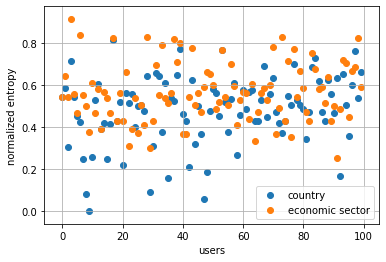

In [64]:
fig, ax = plt.subplots()
ax.set_xlabel('users')
ax.set_ylabel('normalized entropy')
ax.scatter(userid_tolerance_normed_df.index.values[:100], userid_tolerance_normed_df.COUNTRY[:100], label='country')
# ax.scatter(userid_tolerance_normed_df.index.values[:100], userid_tolerance_normed_df.LOAN_BUCKET[:100], label='loan bucket')
# ax.scatter(userid_tolerance_normed_df.index.values[:100], userid_tolerance_normed_df.GENDER[:100], label='borrower gender')
ax.scatter(userid_tolerance_normed_df.index.values[:100], userid_tolerance_normed_df.ACTIVITY[:100], label='economic sector')
# ax.scatter(userid_tolerance_normed_df.index.values[:100], userid_tolerance_normed_df.PFR_BUCKET[:100], label='percentage funding rate')
# ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
ax.legend()
ax.grid(True)
plt.savefig('./UMAP2020_CameraReady/ent_diff_pro_kiva.png')
plt.show()

### user entropy distribution

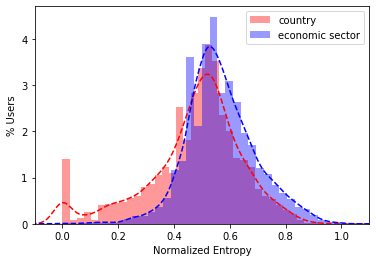

In [138]:
fig, ax = plt.subplots()
ax.hist(sorted(userid_tolerance_normed_df['COUNTRY']), color = 'red', alpha=0.4,
             bins = int(180/5), label='country', density=True)

ax.hist(sorted(userid_tolerance_normed_df['ACTIVITY']), color = 'blue',
             bins = int(180/5), alpha=0.4, label='economic sector', density=True)

plt.legend()
userid_tolerance_normed_df['COUNTRY'].plot.kde(ax=ax, legend=False, color='red', ls='--')
userid_tolerance_normed_df['ACTIVITY'].plot.kde(ax=ax, legend=False, color='blue', ls='--')

# ax.set_ylim([0.0, 1.0])
ax.set_xlim([-0.1,1.1])
ax.set_xlabel('Normalized Entropy')
ax.set_ylabel('% Users')
plt.savefig('./UMAP2020_CameraReady/kiva_user_entropy_distribitions_lineDist.png', dpi=300)

## "country" and "economic sector" are our sensitive attribute.

In [65]:
items = list(range(dataset.item_n))
print(dataset.item_n)

training_item_features_df_unique = item_features_df[item_features_df.index.isin(items)]
training_item_features_df_unique.head()

2673


,ACTIVITY_Agriculture,ACTIVITY_Air Conditioning,ACTIVITY_Animal Sales,ACTIVITY_Aquaculture,ACTIVITY_Arts,ACTIVITY_Auto Repair,ACTIVITY_Bakery,ACTIVITY_Barber Shop,ACTIVITY_Beauty Salon,ACTIVITY_Beekeeping,...,loan_buck_4,loan_buck_5,loan_buck_6,loan_buck_7,loan_buck_8,loan_buck_9,pfr_buck_0,pfr_buck_1,pfr_buck_2,pfr_buck_3
innerID,,,,,,,,,,,,,,,,,,,,,
2655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1499,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2201,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
546,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [66]:
all_item_feature_count = np.sum(training_item_features_df_unique.to_numpy(), axis=0)
all_item_feature_count = pd.DataFrame([all_item_feature_count], columns=training_item_features_df_unique.columns)
all_item_feature_count = pd.DataFrame(all_item_feature_count.T).rename(columns={0:'count'})
all_item_feature_count.index.name = 'cat'
all_item_feature_count

,count
cat,
ACTIVITY_Agriculture,94
ACTIVITY_Air Conditioning,0
ACTIVITY_Animal Sales,39
ACTIVITY_Aquaculture,10
ACTIVITY_Arts,10
...,...
loan_buck_9,268
pfr_buck_0,669
pfr_buck_1,668


In [67]:
feat_dict.keys()

dict_keys(['ACTIVITY', 'COUNTRY', 'GENDER', 'LOAN_BUCKET', 'PFR_BUCKET'])

In [68]:
freq_count = pd.DataFrame(columns=['cat', 'count'])

for key in feat_dict.keys():
    a_df = all_item_feature_count[all_item_feature_count.index.isin(feat_dict[key])]
    a_df_perc = a_df * 100.0 / a_df.sum() # divide by the total number of occurences in that catgory.
    a_df_perc = a_df_perc.reset_index(inplace=False)
    a_df_perc.columns = ['cat', 'count']
    freq_count = pd.concat([freq_count, a_df_perc], axis = 0)

freq_count.sort_values(by='cat', inplace=True)
freq_count.set_index('cat', inplace=True)
genre_all_item_count = freq_count

In [69]:
genre_all_item_count.shape

(231, 1)

In [70]:
genre_all_item_count[genre_all_item_count.index.isin(feat_dict['COUNTRY'])].sum()

count    100.0
dtype: float64

In [71]:
genre_all_item_count[genre_all_item_count.index.isin(feat_dict['COUNTRY'])].T

cat,COUNTRY_Albania,COUNTRY_Armenia,COUNTRY_Bolivia,COUNTRY_Brazil,COUNTRY_Burkina Faso,COUNTRY_Cambodia,COUNTRY_Cameroon,COUNTRY_Colombia,COUNTRY_Congo (DRC),COUNTRY_Costa Rica,...,COUNTRY_Timor-Leste,COUNTRY_Togo,COUNTRY_Turkey,COUNTRY_Uganda,COUNTRY_Ukraine,COUNTRY_United States,COUNTRY_Vietnam,COUNTRY_Yemen,COUNTRY_Zambia,COUNTRY_Zimbabwe
count,0.673401,1.571268,3.179948,1.084923,1.384212,3.554059,1.159746,3.59147,2.543958,0.448934,...,0.561167,1.646091,0.0,3.142536,0.486345,1.459035,1.084923,0.187056,0.3367,1.646091


In [72]:
genre_all_item_count['count']

cat
ACTIVITY_Agriculture          3.516648
ACTIVITY_Air Conditioning     0.000000
ACTIVITY_Animal Sales         1.459035
ACTIVITY_Aquaculture          0.374111
ACTIVITY_Arts                 0.374111
                               ...    
loan_buck_9                  10.026188
pfr_buck_0                   25.028058
pfr_buck_1                   24.990647
pfr_buck_2                   24.990647
pfr_buck_3                   24.990647
Name: count, Length: 231, dtype: float64

Text(0, 0.5, 'percentage')

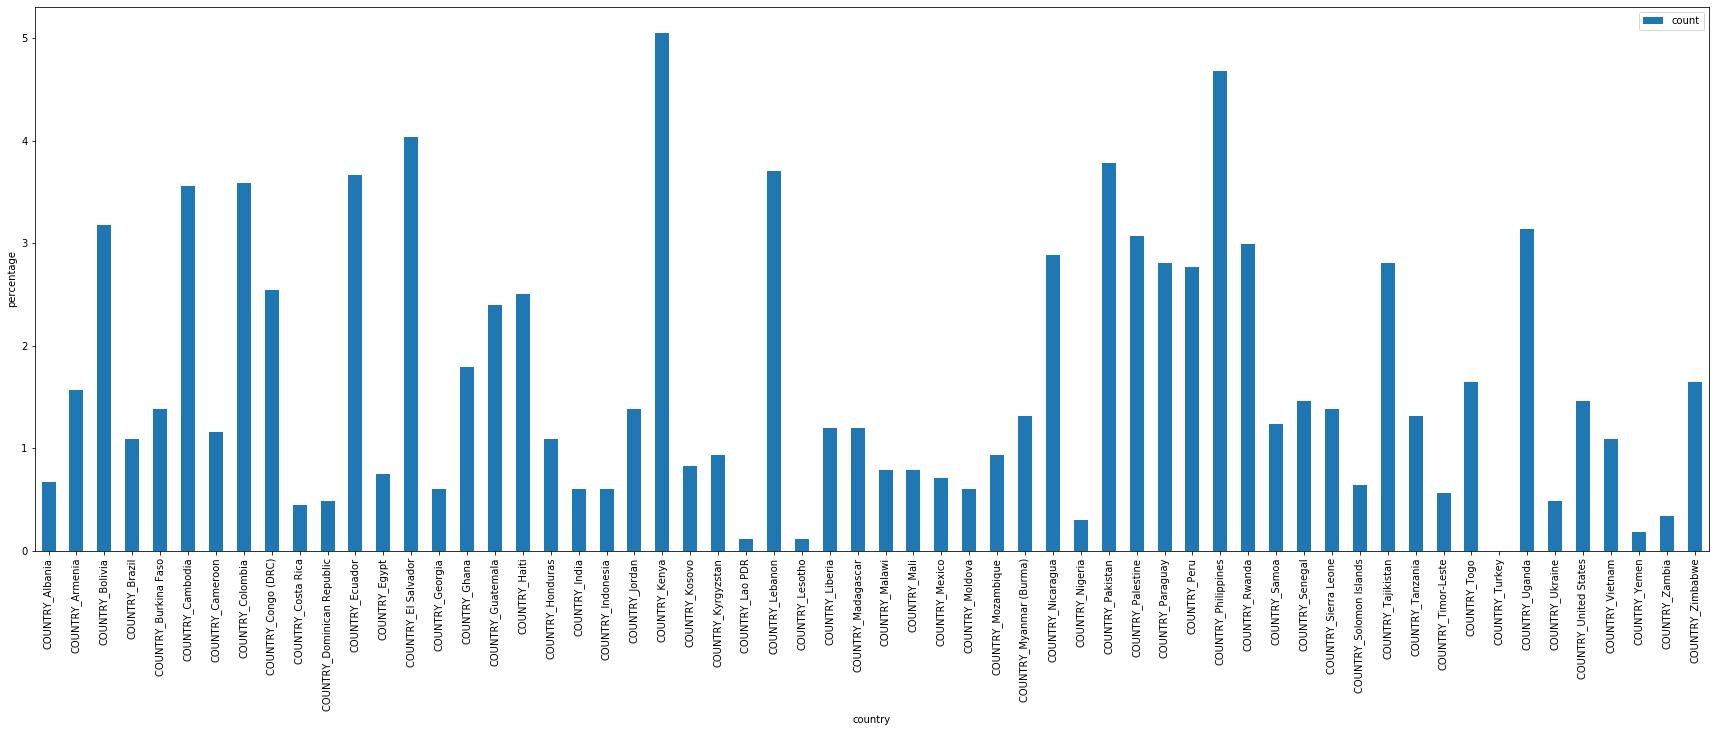

In [73]:
countries_df = genre_all_item_count[genre_all_item_count.index.isin(feat_dict['COUNTRY'])]
countries_df.plot(kind='bar', figsize=(30, 10))
plt.xlabel('country')
plt.ylabel('percentage')

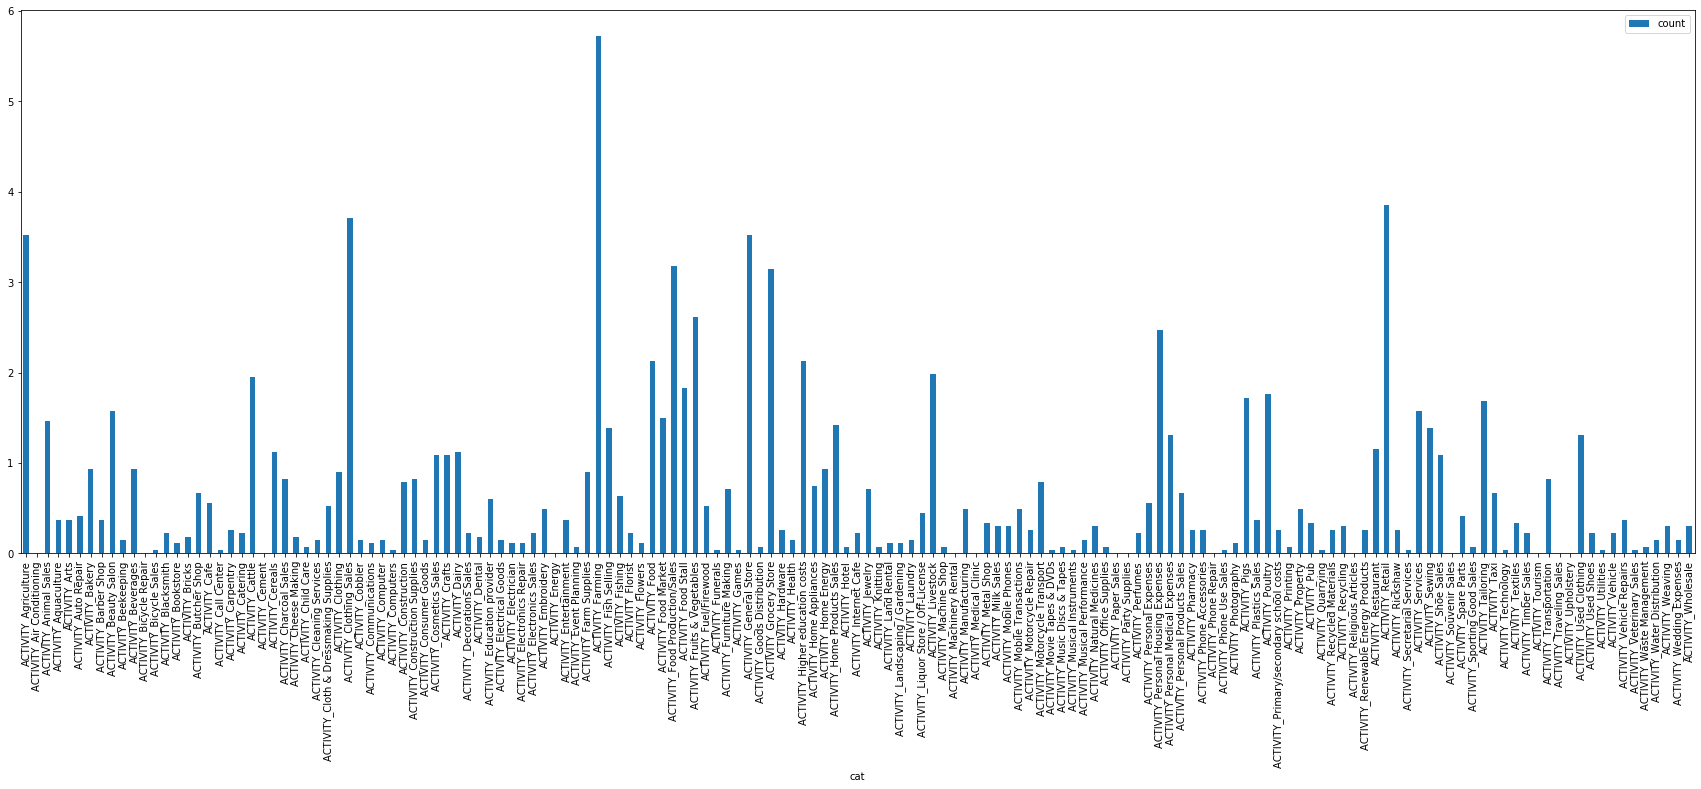

In [74]:
activity_df = genre_all_item_count[genre_all_item_count.index.isin(feat_dict['ACTIVITY'])]
activity_df.plot(kind='bar', figsize=(30, 10))

### protected group

In [75]:
print(activity_df.index)
activity_df.to_csv('./UMAP2020_CameraReady/activities.csv')

Index(['ACTIVITY_Agriculture', 'ACTIVITY_Air Conditioning',
       'ACTIVITY_Animal Sales', 'ACTIVITY_Aquaculture', 'ACTIVITY_Arts',
       'ACTIVITY_Auto Repair', 'ACTIVITY_Bakery', 'ACTIVITY_Barber Shop',
       'ACTIVITY_Beauty Salon', 'ACTIVITY_Beekeeping',
       ...
       'ACTIVITY_Used Shoes', 'ACTIVITY_Utilities', 'ACTIVITY_Vehicle',
       'ACTIVITY_Vehicle Repairs', 'ACTIVITY_Veterinary Sales',
       'ACTIVITY_Waste Management', 'ACTIVITY_Water Distribution',
       'ACTIVITY_Weaving', 'ACTIVITY_Wedding Expenses', 'ACTIVITY_Wholesale'],
      dtype='object', name='cat', length=155)


In [76]:
countries_df.index

Index(['COUNTRY_Albania', 'COUNTRY_Armenia', 'COUNTRY_Bolivia',
       'COUNTRY_Brazil', 'COUNTRY_Burkina Faso', 'COUNTRY_Cambodia',
       'COUNTRY_Cameroon', 'COUNTRY_Colombia', 'COUNTRY_Congo (DRC)',
       'COUNTRY_Costa Rica', 'COUNTRY_Dominican Republic', 'COUNTRY_Ecuador',
       'COUNTRY_Egypt', 'COUNTRY_El Salvador', 'COUNTRY_Georgia',
       'COUNTRY_Ghana', 'COUNTRY_Guatemala', 'COUNTRY_Haiti',
       'COUNTRY_Honduras', 'COUNTRY_India', 'COUNTRY_Indonesia',
       'COUNTRY_Jordan', 'COUNTRY_Kenya', 'COUNTRY_Kosovo',
       'COUNTRY_Kyrgyzstan', 'COUNTRY_Lao PDR', 'COUNTRY_Lebanon',
       'COUNTRY_Lesotho', 'COUNTRY_Liberia', 'COUNTRY_Madagascar',
       'COUNTRY_Malawi', 'COUNTRY_Mali', 'COUNTRY_Mexico', 'COUNTRY_Moldova',
       'COUNTRY_Mozambique', 'COUNTRY_Myanmar (Burma)', 'COUNTRY_Nicaragua',
       'COUNTRY_Nigeria', 'COUNTRY_Pakistan', 'COUNTRY_Palestine',
       'COUNTRY_Paraguay', 'COUNTRY_Peru', 'COUNTRY_Philippines',
       'COUNTRY_Rwanda', 'COUNTRY_Samoa', 'C

In [77]:
# pro_countries = countries_df[(countries_df['count'] < 2) & (countries_df['count'] > 1)].index.tolist()
pro_countries = countries_df[(countries_df['count'] < 1)].index.tolist()
pro_countries

['COUNTRY_Albania',
 'COUNTRY_Costa Rica',
 'COUNTRY_Dominican Republic',
 'COUNTRY_Egypt',
 'COUNTRY_Georgia',
 'COUNTRY_India',
 'COUNTRY_Indonesia',
 'COUNTRY_Kosovo',
 'COUNTRY_Kyrgyzstan',
 'COUNTRY_Lao PDR',
 'COUNTRY_Lesotho',
 'COUNTRY_Malawi',
 'COUNTRY_Mali',
 'COUNTRY_Mexico',
 'COUNTRY_Moldova',
 'COUNTRY_Mozambique',
 'COUNTRY_Nigeria',
 'COUNTRY_Solomon Islands',
 'COUNTRY_Timor-Leste',
 'COUNTRY_Turkey',
 'COUNTRY_Ukraine',
 'COUNTRY_Yemen',
 'COUNTRY_Zambia']

In [78]:
countries_df['count'].shape

(60,)

In [79]:
# genre_all_item_count[genre_all_item_count.index.isin(feat_dict['GENDER'])].plot(kind='bar', figsize=(30, 10))

In [80]:
feat_dict.keys()

dict_keys(['ACTIVITY', 'COUNTRY', 'GENDER', 'LOAN_BUCKET', 'PFR_BUCKET'])

In [81]:
# pro_activities = activity_df[activity_df['count'] < 0.2].index.tolist()
# pro_activities
# let's pick them manually
pro_activities = ['ACTIVITY_Child Care', 'ACTIVITY_Medical Clinic', 'ACTIVITY_Health', 'ACTIVITY_Waste Management','ACTIVITY_Water Distribution']
pro_activities

['ACTIVITY_Child Care',
 'ACTIVITY_Medical Clinic',
 'ACTIVITY_Health',
 'ACTIVITY_Waste Management',
 'ACTIVITY_Water Distribution']

### multiple lambdas - selecting multiple genres to increase their exposure

In [82]:
genre_all_item_count.head()

,count
cat,
ACTIVITY_Agriculture,3.516648
ACTIVITY_Air Conditioning,0.000000
ACTIVITY_Animal Sales,1.459035
ACTIVITY_Aquaculture,0.374111
ACTIVITY_Arts,0.374111


In [83]:
user_genre_matrix_df.head()

,ACTIVITY_Agriculture,ACTIVITY_Air Conditioning,ACTIVITY_Animal Sales,ACTIVITY_Aquaculture,ACTIVITY_Arts,ACTIVITY_Auto Repair,ACTIVITY_Bakery,ACTIVITY_Barber Shop,ACTIVITY_Beauty Salon,ACTIVITY_Beekeeping,...,loan_buck_4,loan_buck_5,loan_buck_6,loan_buck_7,loan_buck_8,loan_buck_9,pfr_buck_0,pfr_buck_1,pfr_buck_2,pfr_buck_3
userid,,,,,,,,,,,,,,,,,,,,,
0,0.541210,0.541210,0.541210,0.541210,0.541210,0.541210,0.541210,0.541210,0.541210,0.541210,...,0.427388,0.427388,0.427388,0.427388,0.427388,0.427388,0.313566,0.313566,0.313566,0.313566
1,0.641006,0.641006,0.641006,0.641006,0.641006,0.641006,0.641006,0.641006,0.641006,0.641006,...,0.510979,0.510979,0.510979,0.510979,0.510979,0.510979,0.320471,0.320471,0.320471,0.320471
2,0.544419,0.544419,0.544419,0.544419,0.544419,0.544419,0.544419,0.544419,0.544419,0.544419,...,0.373687,0.373687,0.373687,0.373687,0.373687,0.373687,0.322330,0.322330,0.322330,0.322330
3,0.913832,0.913832,0.913832,0.913832,0.913832,0.913832,0.913832,0.913832,0.913832,0.913832,...,0.540598,0.540598,0.540598,0.540598,0.540598,0.540598,0.338430,0.338430,0.338430,0.338430
4,0.555160,0.555160,0.555160,0.555160,0.555160,0.555160,0.555160,0.555160,0.555160,0.555160,...,0.498249,0.498249,0.498249,0.498249,0.498249,0.498249,0.334491,0.334491,0.334491,0.334491


In [84]:
# pro_countries.append('ACTIVITY_Arts')
# pro_countries.append('ACTIVITY_Bakery')

### setting all the weights for countries to 1 and the protected countries to 10

In [85]:
print(pro_countries, len(pro_countries))

['COUNTRY_Albania', 'COUNTRY_Costa Rica', 'COUNTRY_Dominican Republic', 'COUNTRY_Egypt', 'COUNTRY_Georgia', 'COUNTRY_India', 'COUNTRY_Indonesia', 'COUNTRY_Kosovo', 'COUNTRY_Kyrgyzstan', 'COUNTRY_Lao PDR', 'COUNTRY_Lesotho', 'COUNTRY_Malawi', 'COUNTRY_Mali', 'COUNTRY_Mexico', 'COUNTRY_Moldova', 'COUNTRY_Mozambique', 'COUNTRY_Nigeria', 'COUNTRY_Solomon Islands', 'COUNTRY_Timor-Leste', 'COUNTRY_Turkey', 'COUNTRY_Ukraine', 'COUNTRY_Yemen', 'COUNTRY_Zambia'] 23


In [86]:
# fairness_weights_man = genre_all_item_count.T.copy()
# # fairness_weights_man[fairness_weights_man.columns] = 0

# fairness_weights_man[feat_dict['COUNTRY']] = 1

# for fee in pro_countries:
#     fairness_weights_man[fee] = 10

# fairness_weights_man = fairness_weights_man.T
# # fairness_weights_man[[pro_countries]]

# multidimensional fairness

### setting the activities to 1 and the protected activities to 10

In [87]:
fairness_weights_man = genre_all_item_count.T.copy()

fairness_weights_man[feat_dict['ACTIVITY']] = 1
fairness_weights_man[feat_dict['COUNTRY']] = 1

for fee in pro_countries:
    fairness_weights_man[fee] = 100

for fee in pro_activities:
    fairness_weights_man[fee] = 100

fairness_weights_man = fairness_weights_man.T

In [88]:
fairness_weights_man.loc['ACTIVITY_Child Care']

count    100.0
Name: ACTIVITY_Child Care, dtype: float64

In [89]:
fairness_weights_man.T[item_features_df.columns]

cat,ACTIVITY_Agriculture,ACTIVITY_Air Conditioning,ACTIVITY_Animal Sales,ACTIVITY_Aquaculture,ACTIVITY_Arts,ACTIVITY_Auto Repair,ACTIVITY_Bakery,ACTIVITY_Barber Shop,ACTIVITY_Beauty Salon,ACTIVITY_Beekeeping,...,loan_buck_4,loan_buck_5,loan_buck_6,loan_buck_7,loan_buck_8,loan_buck_9,pfr_buck_0,pfr_buck_1,pfr_buck_2,pfr_buck_3
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,10.213244,9.839132,9.913954,9.951366,9.988777,10.026188,25.028058,24.990647,24.990647,24.990647


In [90]:
list(item_features_df.columns).index('COUNTRY_India')

176

In [91]:
# user_genre_matrix_df[item_features_df.columns].loc[0].to_numpy()

In [92]:
print(fairness_weights_man.loc[pro_countries].keys)

<bound method NDFrame.keys of                             count
cat                              
COUNTRY_Albania             100.0
COUNTRY_Costa Rica          100.0
COUNTRY_Dominican Republic  100.0
COUNTRY_Egypt               100.0
COUNTRY_Georgia             100.0
COUNTRY_India               100.0
COUNTRY_Indonesia           100.0
COUNTRY_Kosovo              100.0
COUNTRY_Kyrgyzstan          100.0
COUNTRY_Lao PDR             100.0
COUNTRY_Lesotho             100.0
COUNTRY_Malawi              100.0
COUNTRY_Mali                100.0
COUNTRY_Mexico              100.0
COUNTRY_Moldova             100.0
COUNTRY_Mozambique          100.0
COUNTRY_Nigeria             100.0
COUNTRY_Solomon Islands     100.0
COUNTRY_Timor-Leste         100.0
COUNTRY_Turkey              100.0
COUNTRY_Ukraine             100.0
COUNTRY_Yemen               100.0
COUNTRY_Zambia              100.0>


In [93]:
print(fairness_weights_man.loc[pro_activities].keys)

<bound method NDFrame.keys of                              count
cat                               
ACTIVITY_Child Care          100.0
ACTIVITY_Medical Clinic      100.0
ACTIVITY_Health              100.0
ACTIVITY_Waste Management    100.0
ACTIVITY_Water Distribution  100.0>


In [94]:
# fairness_weights_man.T[item_features_df.columns].to_numpy()[0]

### we have two protected attribute: activity and country

# MMR + tolerance weight + fairness weight

In [95]:
start = timeit.default_timer()
for lam in [0.2, 0.4, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85,0.87, 0.9,0.93, 0.95, 0.97, 0.99, 1.0]:
    
    print(lam)
    top_k = 10

    def compute_mmr_selective_fairness(u):
        
        # get the user specific tolerance weight 
        u_tol_w = fairness_weights_man.T[item_features_df.columns].to_numpy()[0] * user_genre_matrix_df[item_features_df.columns].loc[u].to_numpy()
        
        return (u, mmr_opt(u, item_features_df, lam, top_k, u_tol_w))


    pool = Pool(processes=20)
    user_recs_ent_fairness = pool.map(compute_mmr_selective_fairness, list(range(dataset.user_n)))
    pool.close()
    pool.join()
    pool.terminate()

    save_recommendations(user_recs_ent_fairness, 'rec_tol_fair_MMR_lam%s_twoFeature100.csv'%lam)

stop = timeit.default_timer()
print('Process Time: %.2f secs' % (stop - start))

0.2
0.4
0.6
0.65
0.7
0.75
0.8
0.85
0.87
0.9
0.93
0.95
0.97
0.99
1.0
Process Time: 1163.48 secs


# MMR + only fairness weights

In [ ]:
start = timeit.default_timer()
for lam in [0.2, 0.4, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.87, 0.9, 0.93, 0.95, 0.97, 0.99, 1.0]:
    
    print(lam)
    top_k = 10

    def compute_mmr_selective_fairness(u):
        # get the user specific tolerance weight 
        u_f = fairness_weights_man.T[item_features_df.columns].to_numpy()[0] 
        
        return (u, mmr_opt(u, item_features_df, lam, top_k, u_f))


    pool = Pool(processes=20)
    user_recs_ent_fairness = pool.map(compute_mmr_selective_fairness, list(range(dataset.user_n)))
    pool.close()
    pool.join()
    pool.terminate()

    save_recommendations(user_recs_ent_fairness, 'rec_fair_MMR_lam%stwoFeature100.csv'%lam)

stop = timeit.default_timer()
print('Process Time: %.2f secs' % (stop - start))

0.2
0.4
0.6
0.65
0.7
0.75
0.8


In [109]:
genre_dist_rerankings = []

In [110]:
# interested_fs = feat_dict['COUNTRY'] + ['ACTIVITY_Bakery', 'ACTIVITY_Arts']

In [111]:
interested_fs = feat_dict['COUNTRY'] + feat_dict['ACTIVITY']

In [112]:
genre_dist_rerankings = np.zeros((len(interested_fs)))
for u in range(500):#dataset.user_n):
    for item in user_recs_ent_fairness[u][1][1]:
#         print(item)
        try:
#             print(item_features_df.loc[item, feat_dict['COUNTRY']].values)
            genre_dist_rerank += item_features_df.loc[item, interested_fs].values
        except IndexError:
            pass
        
genre_dist_rerankings.append((genre_dist_rerank, 'lam=0.1 all country&activity=1 and (country_pr & activity_pr)=10')) # 

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [113]:
import matplotlib
d = 0.1
inc = 0
for g in genre_dist_rerankings:
    plt.bar(np.arange(len(interested_fs)) + inc, g[0], d, label=g[1])
    inc += d

plt.gca().set_xticklabels(interested_fs)
plt.gca().set_xticks(np.arange(len(interested_fs)) + 0.1)
plt.setp(plt.gca().get_xticklabels(), rotation=60, horizontalalignment='right')
plt.legend(loc='best')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(25, 6)
plt.show()

IndexError: invalid index to scalar variable.

In [108]:
print(fairness_weights_man.loc[pro_countries].keys)

<bound method NDFrame.keys of                             count
cat                              
COUNTRY_Albania             100.0
COUNTRY_Costa Rica          100.0
COUNTRY_Dominican Republic  100.0
COUNTRY_Egypt               100.0
COUNTRY_Georgia             100.0
COUNTRY_India               100.0
COUNTRY_Indonesia           100.0
COUNTRY_Kosovo              100.0
COUNTRY_Kyrgyzstan          100.0
COUNTRY_Lao PDR             100.0
COUNTRY_Lesotho             100.0
COUNTRY_Malawi              100.0
COUNTRY_Mali                100.0
COUNTRY_Mexico              100.0
COUNTRY_Moldova             100.0
COUNTRY_Mozambique          100.0
COUNTRY_Nigeria             100.0
COUNTRY_Solomon Islands     100.0
COUNTRY_Timor-Leste         100.0
COUNTRY_Turkey              100.0
COUNTRY_Ukraine             100.0
COUNTRY_Yemen               100.0
COUNTRY_Zambia              100.0>


In [103]:
print(fairness_weights_man.loc[pro_activities].keys)

<bound method NDFrame.keys of                              count
cat                               
ACTIVITY_Child Care          100.0
ACTIVITY_Medical Clinic      100.0
ACTIVITY_Health              100.0
ACTIVITY_Waste Management    100.0
ACTIVITY_Water Distribution  100.0>
